In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Inspect Measurement Class
first_row_m = session.query(Measurement).first()
first_row_m.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2c071b51150>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

In [10]:
# Inspect Station Class
first_row_s = session.query(Station).first()
first_row_s.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2c071b68450>,
 'longitude': -157.8168,
 'station': 'USC00519397',
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'id': 1,
 'elevation': 3.0}

In [11]:
m_num_rows = session.query(Measurement).count()
m_num_rows

19550

In [12]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

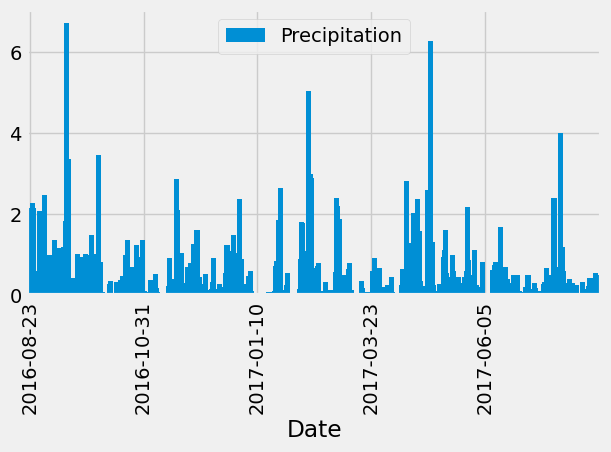

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Measurement.prcp

# Calculate the date one year from the last date in data set.
most_recent_dt = dt.date(2017, 8, 23)
one_year_ago = most_recent_dt - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data_year = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_data_df = pd.DataFrame(precip_data_year, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precip_data_df_sorted = precip_data_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precip_data_df_sorted.set_index('Date', inplace=True)
precip_data_df_sorted.plot(kind='bar', width=20)
plt.tight_layout()
# Choose only 5 x-axis labels for better readability
plt.xticks(plt.xticks()[0][::int(len(precip_data_df_sorted) / 5)])
plt.show()

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precip_data_df_sorted.describe()
summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station).count()
station_count

9

In [16]:
# Look at Station Class to see what it contains
session.query(Station.longitude, Station.station, Station.name, Station.latitude, Station.id, Station.elevation).all()

[(-157.8168, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, 1, 3.0),
 (-157.8015, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, 2, 14.6),
 (-157.8374, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, 3, 7.0),
 (-157.9751, 'USC00517948', 'PEARL CITY, HI US', 21.3934, 4, 11.9),
 (-158.0111, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, 5, 306.6),
 (-157.71139, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, 6, 19.5),
 (-157.84888999999998, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, 7, 32.9),
 (-157.9992, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, 8, 0.9),
 (-157.8025, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, 9, 152.4)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# 'USC00519281' -- from previous query
most_active_station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').first()
most_active_station_stats

(54.0, 85.0, 71.66378066378067)

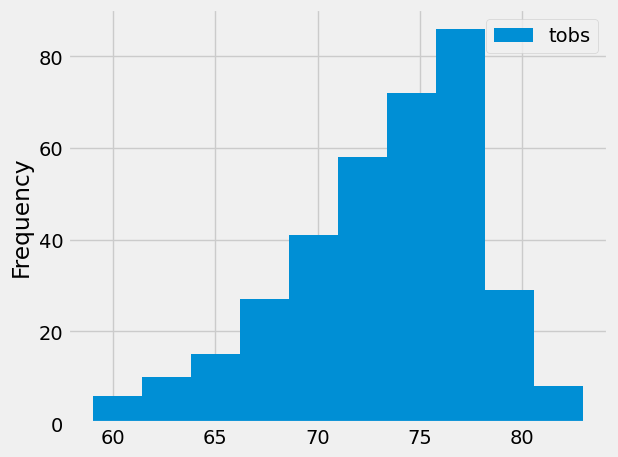

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Calculate the date one year from the last date in data set.
most_recent_dt = dt.date(2017, 8, 23)
one_year_ago = most_recent_dt - dt.timedelta(days=365)

# Perform a query to retrieve the data and temperatures
most_active_station_temps_year = session.query(Measurement.tobs).\
filter(Measurement.date >= one_year_ago).\
filter(Measurement.station == 'USC00519281').all()

# Save the query results as a Pandas DataFrame.
USC00519281_temps_year_df = pd.DataFrame(most_active_station_temps_year, columns=['tobs'])
USC00519281_temps_year_df

USC00519281_temps_year_df['tobs'] = pd.to_numeric(USC00519281_temps_year_df['tobs'])

USC00519281_temps_year_df.plot(kind='hist')
plt.tight_layout()
plt.show()

# Close Session

In [20]:
# Close Session
#session.close()

In [21]:
stations_list = session.query(Measurement.station).group_by(Measurement.station).all()
stations_list

[('USC00511918',),
 ('USC00513117',),
 ('USC00514830',),
 ('USC00516128',),
 ('USC00517948',),
 ('USC00518838',),
 ('USC00519281',),
 ('USC00519397',),
 ('USC00519523',)]